In [1]:
import yfinance as yfn
import pandas as pan
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500=read_csv("sp500.csv", index_col=0)
else:
    sp500=yfn.Ticker("^GSPC")
    sp500=sp500.history(period="max")
    sp500.to_csv("sp500")

In [3]:
sp500.index=pan.to_datetime(sp500.index)
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-30 00:00:00-04:00,5478.729980,5489.459961,5401.700195,5436.439941,3777740000,0.0,0.0
2024-07-31 00:00:00-04:00,5505.589844,5551.509766,5493.750000,5522.299805,4546910000,0.0,0.0
2024-08-01 00:00:00-04:00,5537.839844,5566.160156,5410.419922,5446.680176,4703620000,0.0,0.0


<Axes: xlabel='Date'>

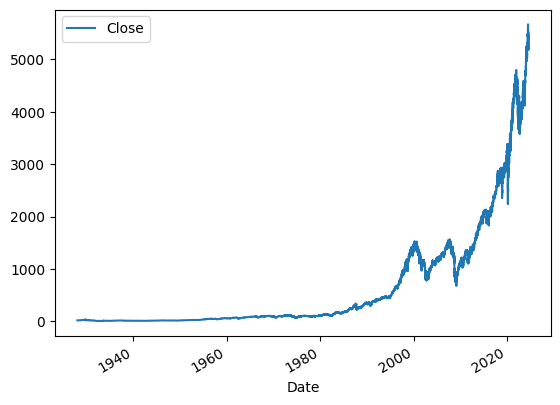

In [4]:
sp500.plot.line(y="Close", use_index=True)

In [5]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [6]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tomorrow"]>sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Open", "High", "Low", "Close", "Volume"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [13]:
from sklearn.metrics import precision_score
pred = model.predict(test[predictors])
pred = pan.Series(pred, index=test.index)
precision_score(test["Target"], pred)

0.5384615384615384

<Axes: xlabel='Date'>

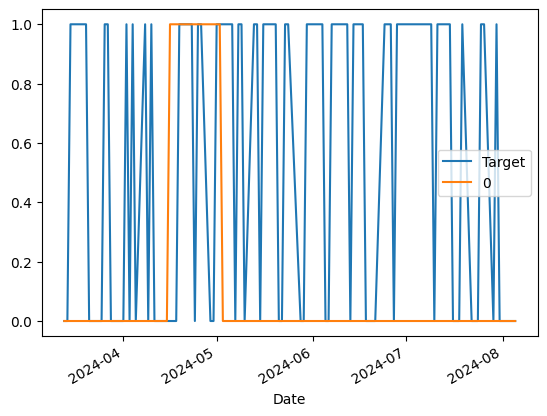

In [16]:
new = pan.concat([test["Target"], pred], axis=1)
new.plot()

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    pred = model.predict(test[predictors])
    pred = pan.Series(pred, index=test.index, name="Predictions")
    new = pan.concat([test["Target"], pred], axis=1)
    return new

In [32]:
def backtesting(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)  
    return pan.concat(all_predictions)

In [33]:
predictions = backtesting(sp500, model, predictors)

In [34]:
predictions["Predictions"].value_counts()

Predictions
0    1853
1    1833
Name: count, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5275504637206765

In [36]:
predictions["Target"].value_counts()/predictions.shape[0]

Target
1    0.544221
0    0.455779
Name: count, dtype: float64

In [46]:
tset = [2,5,60,250,1000]
new_predictors = []

for ts in tset:
    rolling_averages = sp500.rolling(ts).mean()
    
    ratio_column = f"Close_Ratio_{ts}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{ts}"
    sp500[trend_column] = sp500.shift(1).rolling(ts).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

C:\Users\NISHANT PUNDIR\AppData\Local\Temp\ipykernel_20856\1130530669.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
C:\Users\NISHANT PUNDIR\AppData\Local\Temp\ipykernel_20856\1130530669.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[trend_column] = sp500.shift(1).rolling(ts).sum()["Target"]


In [47]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [48]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,CloseRatio_2,CloseRatio_5,CloseRatio_60,CloseRatio_250,CloseRatio_1000,CloseRatio2,CloseRatio5,CloseRatio60,CloseRatio250,CloseRatio1000
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-05 00:00:00-05:00,1244.329956,1266.729980,1244.329956,1257.079956,4148060000,1258.469971,1,1.005117,1.0,1.015725,...,1.005117,1.015725,1.041473,0.991178,1.097694,1.005117,1.015725,1.041473,0.991178,1.097694
2011-12-06 00:00:00-05:00,1257.189941,1266.030029,1253.030029,1258.469971,3734230000,1261.010010,1,1.000553,2.0,1.006555,...,1.000553,1.006555,1.041241,0.992194,1.099097,1.000553,1.006555,1.041241,0.992194,1.099097
2011-12-07 00:00:00-05:00,1258.140015,1267.060059,1244.800049,1261.010010,4160540000,1234.349976,0,1.001008,2.0,1.006325,...,1.001008,1.006325,1.042077,0.994132,1.101500,1.001008,1.006325,1.042077,0.994132,1.101500
2011-12-08 00:00:00-05:00,1260.869995,1260.869995,1231.469971,1234.349976,4298370000,1255.189941,1,0.989316,1.0,0.986661,...,0.989316,0.986661,1.019404,0.973133,1.078425,0.989316,0.986661,1.019404,0.973133,1.078425
2011-12-09 00:00:00-05:00,1234.479980,1258.250000,1234.479980,1255.189941,3830610000,1236.469971,0,1.008371,1.0,1.001572,...,1.008371,1.001572,1.035958,0.989520,1.096852,1.008371,1.001572,1.035958,0.989520,1.096852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-30 00:00:00-04:00,5478.729980,5489.459961,5401.700195,5436.439941,3777740000,5522.299805,1,0.997514,1.0,0.999881,...,0.997514,0.999881,1.005836,1.115112,1.268992,0.997514,0.999881,1.005836,1.115112,1.268992
2024-07-31 00:00:00-04:00,5505.589844,5551.509766,5493.750000,5522.299805,4546910000,5446.680176,0,1.007835,1.0,1.012129,...,1.007835,1.012129,1.020480,1.131787,1.288381,1.007835,1.012129,1.020480,1.131787,1.288381
2024-08-01 00:00:00-04:00,5537.839844,5566.160156,5410.419922,5446.680176,4703620000,5346.560059,0,0.993106,1.0,0.996536,...,0.993106,0.996536,1.005682,1.115425,1.270120,0.993106,0.996536,1.005682,1.115425,1.270120


In [49]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [50]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    pred = model.predict_proba(test[predictors])[:,1]
    pred[pred >=.6] = 1
    pred[pred <.6] = 0
    pred = pan.Series(pred, index=test.index, name="Predictions")
    new = pan.concat([test["Target"], pred], axis=1)
    return new

In [51]:
predictions = backtesting(sp500, model, new_predictors)

In [52]:
predictions["Predictions"].value_counts()

Predictions
0.0    552
1.0    134
Name: count, dtype: int64

In [53]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5

In [54]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.504373
0    0.495627
Name: count, dtype: float64

In [55]:
predictions

,Target,Predictions
Date,,
2021-11-10 00:00:00-05:00,1,0.0
2021-11-11 00:00:00-05:00,1,0.0
2021-11-12 00:00:00-05:00,0,0.0
2021-11-15 00:00:00-05:00,1,0.0
2021-11-16 00:00:00-05:00,0,0.0
...,...,...
2024-07-30 00:00:00-04:00,1,0.0
2024-07-31 00:00:00-04:00,0,0.0
2024-08-01 00:00:00-04:00,0,0.0


<Axes: xlabel='Date'>

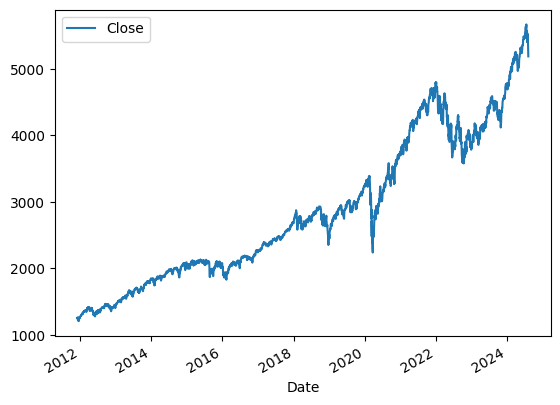

In [56]:
sp500.plot.line(y="Close", use_index=True)